"""
This script is used to analyze data for  supplementary Figure 13 of the manuscript
'Plasmid-mediated phenotypic noise leads to transient antibiotic resistance in bacteria'.

MIT License

Copyright (c) 2023 JCRHB/RPM

""";



#### Fitness Cost - PCN


## System preparation


In [1]:
import pandas as pd
import numpy as np
from scipy.stats import linregress
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.linear_model import LinearRegression
from scipy.stats import pearsonr
from scipy.stats import gaussian_kde


### Mounting Gdrive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading R into notebook

In [3]:
%load_ext rpy2.ipython

### Loading R libraries

In [4]:
%%R
install.packages("growthrates",quiet=TRUE);
install.packages("gridExtra",quiet=TRUE);

library("growthrates");
library(gridExtra);
library(grid);
;

### File paths

In [19]:
rootDir="/content/drive/MyDrive/SYNC_Projects/"

rootDir=rootDir+"pBGT/GIT/"

workingDir=rootDir+"code/Supplementary/"
raw_data_path=rootDir+"data/analysis/fitness/"
kinectics_file=raw_data_path+"Growth_Kinetics_and_competences_all_strains_AMNIS.txt"
data_path=rootDir+"data/supplementary/sFig-13/"

%Rpush kinectics_file


## Load data as table
### Data exported as big matrix from Gen5 plate readers
#### Select the specific txt lines (corresponding to the matrix)

In [20]:
%%R
raw_data=read.table(kinectics_file,sep="\t",dec=".",skip=45,header=T,nrows=73)#,fill=T)

data_table=raw_data[1:200,]
data_table=raw_data
head(data_table)
tail(data_table)

       Time T..OD.630    A1    A2    A3    A4    A5    A6    A7    A8    A9
68 22:20:32        37 0.484 0.520 0.488 0.459 0.542 0.501 0.520 0.530 0.572
69 22:40:32        37 0.478 0.518 0.486 0.456 0.543 0.502 0.514 0.524 0.568
70 23:00:32        37 0.472 0.514 0.483 0.452 0.541 0.499 0.507 0.518 0.565
71 23:20:32        37 0.469 0.513 0.481 0.449 0.543 0.496 0.502 0.515 0.559
72 23:40:32        37 0.466 0.510 0.479 0.445 0.542 0.492 0.502 0.509 0.555
73 24:00:32        37 0.462 0.508 0.478 0.442 0.540 0.490 0.495 0.506 0.545
     A10   A11   A12    B1    B2    B3    B4    B5    B6    B7    B8    B9
68 0.561 0.525 0.623 0.499 0.470 0.505 0.480 0.498 0.550 0.564 0.573 0.520
69 0.563 0.523 0.621 0.494 0.467 0.497 0.475 0.496 0.543 0.558 0.567 0.512
70 0.567 0.520 0.622 0.491 0.466 0.490 0.472 0.493 0.535 0.550 0.559 0.507
71 0.579 0.522 0.624 0.485 0.460 0.487 0.466 0.489 0.525 0.541 0.551 0.502
72 0.586 0.520 0.625 0.482 0.458 0.482 0.461 0.485 0.518 0.534 0.544 0.497
73 0.585 0.518 0.6

## Create the Plate Layout

In [21]:
%%R

c_names=as.character(seq(from=1,to=12))
r_names=LETTERS[seq(from=1,to=8)]
plate = matrix("x", 8, 12)
colnames(plate) <- c_names
rownames(plate) <- r_names

single_strains=c("WT","MGGT","pBGT","G54U","G55U")

strains=c("WTvsMGGT","WTvspBGT","WTvsG54U","WTvsG55U","WT","MGGT","pBGT","pBGT25","pBGT50","G54U","G54U25","G54U50","G55U","G55U25","G55U50")

s1=c("WTvsMGGT","WTvsMGGT","WTvsMGGT","WTvsMGGT","WTvsMGGT","WTvsMGGT","WT","WT","WT","WT","WT","WT")
plate[1,1:12] <- cbind(s1)
s1=c("WTvsMGGT","WTvsMGGT","WTvsMGGT","WTvsMGGT","WTvsMGGT","WTvsMGGT","MGGT","MGGT","MGGT","MGGT","MGGT","MGGT")
plate[2,1:12] <- cbind(s1)
s1=c("WTvspBGT","WTvspBGT","WTvspBGT","WTvspBGT","WTvspBGT","WTvspBGT","pBGT","pBGT","pBGT","pBGT","pBGT","pBGT")
plate[3,1:12] <- cbind(s1)
s1=c("WTvspBGT","WTvspBGT","WTvspBGT","WTvspBGT","WTvspBGT","WTvspBGT","G54U","G54U","G54U","G54U","G54U","G54U")
plate[4,1:12] <- cbind(s1)
s1=c("WTvsG54U","WTvsG54U","WTvsG54U","WTvsG54U","WTvsG54U","WTvsG54U","G55U","G55U","G55U","G55U","G55U","G55U")
plate[5,1:12] <- cbind(s1)
s1=c("WTvsG54U","WTvsG54U","WTvsG54U","WTvsG54U","WTvsG54U","WTvsG54U","pBGT25","pBGT25","pBGT25","pBGT50","pBGT50","pBGT50")
plate[6,1:12] <- cbind(s1)
s1=c("WTvsG55U","WTvsG55U","WTvsG55U","WTvsG55U","WTvsG55U","WTvsG55U","G54U25","G54U25","G54U25","G54U50","G54U50","G54U50")
plate[7,1:12] <- cbind(s1)
s1=c("WTvsG55U","WTvsG55U","WTvsG55U","WTvsG55U","WTvsG55U","WTvsG55U","G55U25","G55U25","G55U25","G55U50","G55U50","G55U50")
plate[8,1:12] <- cbind(s1)


plate

  1          2          3          4          5          6          7       
A "WTvsMGGT" "WTvsMGGT" "WTvsMGGT" "WTvsMGGT" "WTvsMGGT" "WTvsMGGT" "WT"    
B "WTvsMGGT" "WTvsMGGT" "WTvsMGGT" "WTvsMGGT" "WTvsMGGT" "WTvsMGGT" "MGGT"  
C "WTvspBGT" "WTvspBGT" "WTvspBGT" "WTvspBGT" "WTvspBGT" "WTvspBGT" "pBGT"  
D "WTvspBGT" "WTvspBGT" "WTvspBGT" "WTvspBGT" "WTvspBGT" "WTvspBGT" "G54U"  
E "WTvsG54U" "WTvsG54U" "WTvsG54U" "WTvsG54U" "WTvsG54U" "WTvsG54U" "G55U"  
F "WTvsG54U" "WTvsG54U" "WTvsG54U" "WTvsG54U" "WTvsG54U" "WTvsG54U" "pBGT25"
G "WTvsG55U" "WTvsG55U" "WTvsG55U" "WTvsG55U" "WTvsG55U" "WTvsG55U" "G54U25"
H "WTvsG55U" "WTvsG55U" "WTvsG55U" "WTvsG55U" "WTvsG55U" "WTvsG55U" "G55U25"
  8        9        10       11       12      
A "WT"     "WT"     "WT"     "WT"     "WT"    
B "MGGT"   "MGGT"   "MGGT"   "MGGT"   "MGGT"  
C "pBGT"   "pBGT"   "pBGT"   "pBGT"   "pBGT"  
D "G54U"   "G54U"   "G54U"   "G54U"   "G54U"  
E "G55U"   "G55U"   "G55U"   "G55U"   "G55U"  
F "pBGT25" "pBGT25" "pBGT

## Create GrowthRates  package dataframe format
### Create Vmax per strain and replicate dataframe using GrowthRates using fit_easylinear()
### wich implements fitting of linear models to the period of exponential growth using the ``growth rates made easy method’’ of Hall and Barlow (2013)

In [22]:
%%R

time_min=c()
for(time in data_table$Time){

    ttime=as.character(time)
    tv=as.numeric(unlist(strsplit(ttime,":")))
    ttime=(tv[1]*60)+(tv[2])
    time_min=c(time_min,ttime)

}
print(time_min)
time_min=time_min/60

print(time_min)

#strains <-strains[sort.list(strains)]

df_rep=data.frame(strain=union(strains,strains),nreps=c(0))
df_vmax=data.frame()
df_growths=data.frame()

tnames=colnames(data_table)[3:(length(colnames(data_table)))]

#print(tnames)
#tnames=tnames[14:16]
#print(tnames)

for(col in tnames){
    vcol=unlist(strsplit(col,""))
    x=vcol[1]
    if(length(vcol)==3){
        y=paste(vcol[2],vcol[3],sep="")
    }else{
        y=vcol[2]
    }

    strain=plate[x,y]

    if(strain != "x"){
        n=dim(data_table[col])[1]
        vec_ods=as.numeric(gsub(",", ".",data_table[col][1:n,]))

        nrep=df_rep[df_rep["strain"]==strain,][,2]
        nrep=nrep+1
        df_rep[df_rep["strain"]==strain,][,2]=nrep
        this_dfG=data.frame(strain=c(strain),replicate=c(nrep),time=time_min,value=vec_ods)
        df_growths=rbind(df_growths,this_dfG)

        model=fit_easylinear(time_min, vec_ods)
        #print(coef(model))
        this_vmax=coef(model)[2][[1]]
        this_r=rsquared(model)[[1]]
        this_dfV=data.frame(strain=c(strain),vmax=c(this_vmax),r_squared=c(this_r))
        df_vmax=rbind(df_vmax,this_dfV)


    }
}
#df_rep
#head(df_growths)
#df_vmax


 [1]    0   20   40   60   80  100  120  140  160  180  200  220  240  260  280
[16]  300  320  340  360  380  400  420  440  460  480  500  520  540  560  580
[31]  600  620  640  660  680  700  720  740  760  780  800  820  840  860  880
[46]  900  920  940  960  980 1000 1020 1040 1060 1080 1100 1120 1140 1160 1180
[61] 1200 1220 1240 1260 1280 1300 1320 1340 1360 1380 1400 1420 1440
 [1]  0.0000000  0.3333333  0.6666667  1.0000000  1.3333333  1.6666667
 [7]  2.0000000  2.3333333  2.6666667  3.0000000  3.3333333  3.6666667
[13]  4.0000000  4.3333333  4.6666667  5.0000000  5.3333333  5.6666667
[19]  6.0000000  6.3333333  6.6666667  7.0000000  7.3333333  7.6666667
[25]  8.0000000  8.3333333  8.6666667  9.0000000  9.3333333  9.6666667
[31] 10.0000000 10.3333333 10.6666667 11.0000000 11.3333333 11.6666667
[37] 12.0000000 12.3333333 12.6666667 13.0000000 13.3333333 13.6666667
[43] 14.0000000 14.3333333 14.6666667 15.0000000 15.3333333 15.6666667
[49] 16.0000000 16.3333333 16.6666667 17.0

### Plot linear fitting

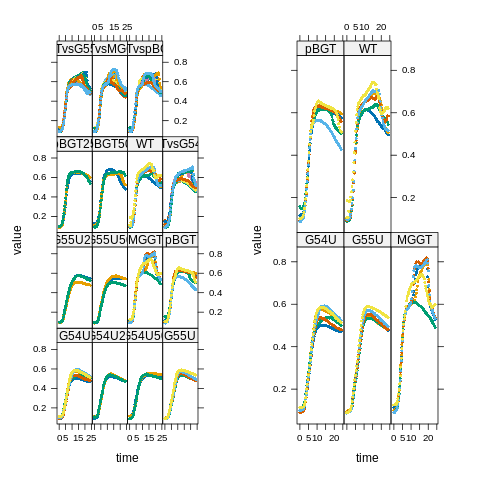

In [23]:
%%R
p1<-xyplot(value ~ time|strain, data = df_growths,groups = replicate, pch = 16, cex = 0.5)
p1

df_growths_single=df_growths[which(df_growths$strain %in% single_strains),]
p2<-xyplot(value ~ time|strain, data = df_growths_single,groups = replicate, pch = 16, cex = 0.5)
p2
grid.arrange(p1, p2, ncol = 2)


In [24]:
%%R
df_vmax_single=df_vmax[which(df_vmax$strain %in% single_strains),]
df_vmax_single

   strain       vmax r_squared
7      WT 0.03757221 0.9994114
8      WT 0.04071474 0.9995275
9      WT 0.03825965 0.9994978
10     WT 0.04133001 0.9993304
11     WT 0.04027707 0.9999080
12     WT 0.08699467 0.8319910
19   MGGT 0.05153075 0.9993778
20   MGGT 0.04793349 0.9996491
21   MGGT 0.04374675 0.9994325
22   MGGT 0.04205981 0.9993560
23   MGGT 0.04261901 0.9994934
24   MGGT 0.05883693 0.9991044
31   pBGT 0.05897546 0.9996360
32   pBGT 0.04648331 0.9995470
33   pBGT 0.07440918 0.9996289
34   pBGT 0.04437205 0.9996163
35   pBGT 0.04312568 0.9996806
36   pBGT 0.05157342 0.9997411
43   G54U 0.04365811 0.9978157
44   G54U 0.04339061 0.9966553
45   G54U 0.05922432 0.9984963
46   G54U 0.03909072 0.9982554
47   G54U 0.04670217 0.9987972
48   G54U 0.05241598 0.9988586
55   G55U 0.04550877 0.9958005
56   G55U 0.04445241 0.9973907
57   G55U 0.03860062 0.9973015
58   G55U 0.04059715 0.9975630
59   G55U 0.03812628 0.9982254
60   G55U 0.04280396 0.9967379


$stats
           [,1]       [,2]       [,3]       [,4]       [,5]
[1,] 0.03909072 0.03812628 0.04205981 0.04312568 0.03757221
[2,] 0.04339061 0.03860062 0.04261901 0.04437205 0.03825965
[3,] 0.04518014 0.04170056 0.04584012 0.04902836 0.04049591
[4,] 0.05241598 0.04445241 0.05153075 0.05897546 0.04133001
[5,] 0.05922432 0.04550877 0.05883693 0.07440918 0.04133001

$n
[1] 6 6 6 6 6

$conf
           [,1]       [,2]       [,3]       [,4]       [,5]
[1,] 0.03935848 0.03792596 0.04009176 0.03960869 0.03851542
[2,] 0.05100180 0.04547515 0.05158848 0.05844804 0.04247639

$out
[1] 0.08699467

$group
[1] 5

$names
[1] "G54U" "G55U" "MGGT" "pBGT" "WT"  



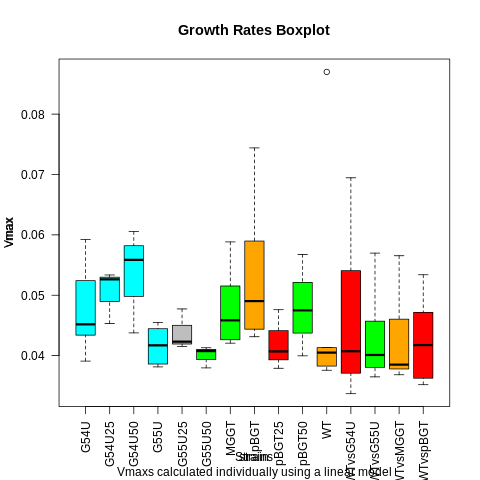

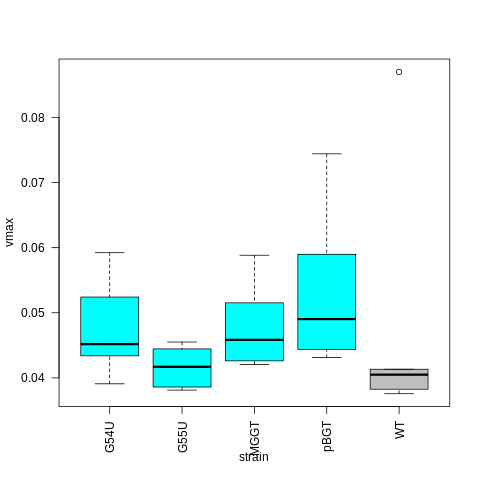

In [25]:
%%R

colors=c("cyan","cyan","cyan","cyan","gray","green","green","orange","red","green","orange","red","green","orange","red")
#colors=rev(colors)
p1_box<-boxplot(vmax ~ strain,df_vmax,col=colors,las=2)
title(main="Growth Rates Boxplot", xlab="Strains", ylab="Vmax",sub="Vmaxs calculated individually using a linear model" )


p2_box<-boxplot(vmax ~ strain,df_vmax_single,col=colors,las=2)
p2_box

In [26]:
%%R

vmax.aov=aov(vmax ~ strain,df_vmax_single)
summary(vmax.aov)
pval=summary(vmax.aov)[[1]][["Pr(>F)"]][[1]]
print("P-value is:")
print(pval)
if(pval<0.05){
    print("This means that there is a significant difference between the group variances/means")
}else{
    print("This means that there is NO significant differences between the group variances/means")
}

[1] "P-value is:"
[1] 0.5401766
[1] "This means that there is NO significant differences between the group variances/means"


In [27]:
%%R

tuk=TukeyHSD(vmax.aov)
tuk

  Tukey multiple comparisons of means
    95% family-wise confidence level

Fit: aov(formula = vmax ~ strain, data = df_vmax_single)

$strain
                   diff          lwr        upr     p adj
G55U-G54U -0.0057321180 -0.024655698 0.01319146 0.8980556
MGGT-G54U  0.0003741373 -0.018549442 0.01929772 0.9999972
pBGT-G54U  0.0057428643 -0.013180715 0.02466644 0.8974383
WT-G54U    0.0001110726 -0.018812507 0.01903465 1.0000000
MGGT-G55U  0.0061062554 -0.012817324 0.02502983 0.8753621
pBGT-G55U  0.0114749824 -0.007448597 0.03039856 0.4062293
WT-G55U    0.0058431907 -0.013080389 0.02476677 0.8915759
pBGT-MGGT  0.0053687270 -0.013554853 0.02429231 0.9177021
WT-MGGT   -0.0002630647 -0.019186644 0.01866051 0.9999993
WT-pBGT   -0.0056317917 -0.024555371 0.01329179 0.9037186



### Any p-value less than 0.05 means that there is a significant diference between the two strains
#### The following list indicates wich ones are different

In [28]:
%%R

df_tuk=as.data.frame(tuk$strain)
df_tuk[ df_tuk["p adj"]<0.05,]


[1] diff  lwr   upr   p adj
<0 rows> (or 0-length row.names)


## Just another way to make the ANOVA

In [29]:
%%R

tapply(df_vmax_single$vmax,df_vmax_single$strain,mean)
vmax.lm=lm(vmax ~ strain,df_vmax_single)
vmax.lm.anova=anova(vmax.lm)
#summary(vmax.lm.anova)
vmax.lm.anova

Analysis of Variance Table

Response: vmax
          Df     Sum Sq    Mean Sq F value Pr(>F)
strain     4 0.00039564 9.8911e-05  0.7941 0.5402
Residuals 25 0.00311385 1.2455e-04               


## Using  fitting models of all strains and replicas
### options are all_easyliner, all_growthmodels and all_splines
#### all_growthmodels is double commented


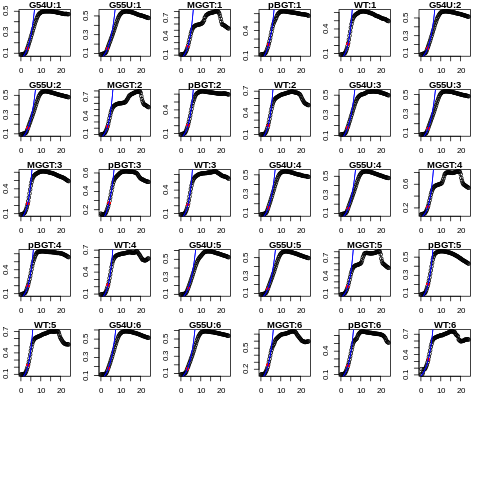

In [30]:
%%R

## p   <- c(y0 = 0.03, mumax = .1, K = 0.1, h0 = 1)

## lower   <- c(y0 = 0.001, mumax = 1e-2, K = 0.005, h0 = 0)
## upper   <- c(y0 = 0.1,   mumax = 1,    K = 0.5,   h0 = 10)

## ## fit growth models to all data using log transformed residuals
## many_fits <- all_growthmodels(
   ##                 value ~ grow_baranyi(time, parms) | strain +  replicate,
    ##                data = df_growths,
     ##               p = p, lower = lower, upper = upper,
      ##              log = "y", ncores = 2);subtxt1="parametric nonlinear growth models"


many_fits_single <- all_splines(value ~ time | strain + replicate, data = df_growths_single, spar = 0.5);subtxt1="nonparametric smoothing splines"
many_fits_single_res   <- results(many_fits_single)

#many_fits_single <- all_easylinear(value ~ time | strain + replicate, data = df_growths_single, spar = 0.5);subtxt1="linear models"
#many_fits_single_res   <- results(many_fits_single2)

many_fits_single_res=as.data.frame(many_fits_single_res)

par(mfrow = c(6, 6))
par(mar = c(2.5, 2, 1, 1))
plot(many_fits_single)

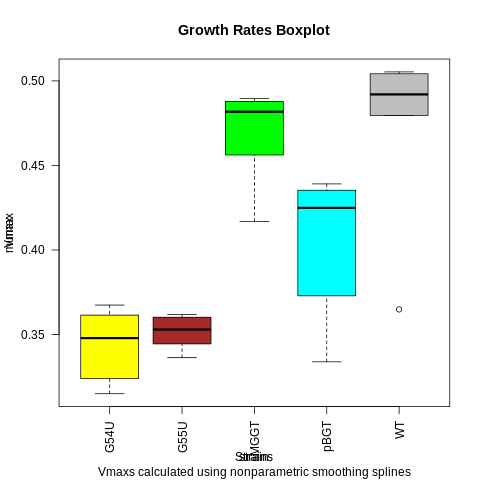

In [31]:
%%R

colors1=c("yellow","brown","green","cyan","gray","gray","gray","gray","purple","red")
#colors2=
boxplot(mumax ~ strain,many_fits_single_res,col=colors1,las=2)
subtxt=paste0("Vmaxs calculated using ",subtxt1)
title(main="Growth Rates Boxplot", xlab="Strains", ylab="Vmax",sub=subtxt )

In [32]:
%%R
single_strains

[1] "WT"   "MGGT" "pBGT" "G54U" "G55U"


In [33]:
%R -o many_fits_single_res

dfname=data_path+"all_strains_vmax.csv"
print("Saving file:",dfname)
many_fits_single_res.to_csv(dfname,sep="\t",index=False)

many_fits_single_res

Saving file: /content/drive/MyDrive/SYNC_Projects/pBGT/GIT/data/supplementary/sFig-13/all_strains_vmax.csv


,strain,replicate,y0,mumax,r2
G54U:1,G54U,1,0.045912,0.354063,0.999748
G55U:1,G55U,1,0.048437,0.344448,0.999680
MGGT:1,MGGT,1,0.048584,0.456196,0.999616
pBGT:1,pBGT,1,0.054732,0.372876,0.999834
WT:1,WT,1,0.035701,0.505315,0.999744
G54U:2,G54U,2,0.045805,0.367420,0.999727
G55U:2,G55U,2,0.047775,0.336322,0.999688
MGGT:2,MGGT,2,0.046332,0.476488,0.999630
pBGT:2,pBGT,2,0.043710,0.435353,0.999757
WT:2,WT,2,0.039392,0.479585,0.999786


In [34]:
%%R

many_fits_single_res.aov=aov(mumax ~ strain,many_fits_single_res)
many_fits_single_res.aov

summary(many_fits_single_res.aov)

pval=summary(many_fits_single_res.aov)[[1]][["Pr(>F)"]][[1]]
print("P-value is:")
print(pval)
if(pval<0.05){
    print("This means that there is a significant difference between the group variances/means")
}else{
    print("This means that there is NO significant differences between the group variances/means")

}



[1] "P-value is:"
[1] 2.915819e-07
[1] "This means that there is a significant difference between the group variances/means"


In [35]:
%%R

tuk_fit=TukeyHSD(many_fits_single_res.aov)
tuk_fit
print("Significant differences:")
df_tuk_fit=as.data.frame(tuk_fit$strain)
df_tuk_fit[df_tuk_fit["p adj"]<0.05,]


[1] "Significant differences:"
                 diff          lwr          upr        p adj
MGGT-G54U  0.12506524  0.066022297  0.184108177 1.536166e-05
pBGT-G54U  0.06123118  0.002188235  0.120274115 3.939318e-02
WT-G54U    0.12906574  0.070022802  0.188108682 9.404050e-06
MGGT-G55U  0.11753953  0.058496586  0.176582465 3.903779e-05
WT-G55U    0.12154003  0.062497091  0.180582970 2.374356e-05
pBGT-MGGT -0.06383406 -0.122877002 -0.004791122 2.947713e-02
WT-pBGT    0.06783457  0.008791627  0.126877507 1.865370e-02
